In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time
import seaborn as sns
import plotly.express as px

<h3>Preprocessing (Loading, removing and showing graphs)</h3>

In [3]:
# Load your CSV dataset (replace 'your_dataset.csv' with your actual dataset)
df = pd.read_csv('/content/drive/MyDrive/ML/Thesis/Dataset/AU-PEMal-2025-V2.csv')

In [4]:
df.head()

,sha1,processes_malicious,processes_monitored,processes_suspicious,total_procsses,files_malicious,files_suspicious,files_unknown,files_text,registry_total,...,text_PointerToRawData,BaseOfCode,BaseOfData,ImageBase,Checksum,SectionAlignment,SizeOfHeaders,Class,Category,Family
0,62f4d55a1bb8396e493d7815dc44febed7161535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1024,4096,16384,5368709120,125136,4096,1024,Benign,Benign,Benign
1,ca40945a4e35d48794a5e13aacf16b8ae1caddeb,0.0,2.0,0.0,93.0,0.0,0.0,0.0,0.0,5.0,...,1024,4096,16384,5368709120,5202495,4096,1024,Benign,Benign,Benign
2,6f47b50480bea61ae4dfb75c12582990cc5ce770,0.0,1.0,0.0,35.0,0.0,0.0,0.0,0.0,58.0,...,512,8192,16384,4194304,0,8192,512,Benign,Benign,Benign
3,8c3d5b506a8d55f42f4c83ead3e4341255d1acfc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1536,4096,16384,4194304,0,4096,1536,Benign,Benign,Benign
4,0a7d0c68c591db2f197b2169d226bebe6e9bdabe,0.0,1.0,0.0,36.0,0.0,0.0,0.0,0.0,253.0,...,512,8192,0,4194304,0,8192,512,Benign,Benign,Benign


In [5]:
df.duplicated().sum()

np.int64(0)

In [6]:
df.shape

(21703, 39)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21703 entries, 0 to 21702
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sha1                     21703 non-null  object 
 1   processes_malicious      21703 non-null  float64
 2   processes_monitored      21703 non-null  float64
 3   processes_suspicious     21703 non-null  float64
 4   total_procsses           21703 non-null  float64
 5   files_malicious          21703 non-null  float64
 6   files_suspicious         21703 non-null  float64
 7   files_unknown            21703 non-null  float64
 8   files_text               21703 non-null  float64
 9   registry_total           21703 non-null  float64
 10  registry_read            21703 non-null  float64
 11  registry_write           21703 non-null  float64
 12  registry_delete          21703 non-null  float64
 13  network_dns              21703 non-null  float64
 14  network_http          

In [8]:
df = df.drop(['sha1','Category', 'Class'], axis=1)
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
categorical_columns =[ 'Family']
df = pd.DataFrame(df)

In [9]:
from sklearn.preprocessing import LabelEncoder
# Initialize the label encoder
label_encoder = LabelEncoder()

# Apply label encoding to each categorical column
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

In [10]:
df.isnull().sum()

,0
processes_malicious,0
processes_monitored,0
processes_suspicious,0
total_procsses,0
files_malicious,0
files_suspicious,0
files_unknown,0
files_text,0
registry_total,0
registry_read,0


##Outliers ##

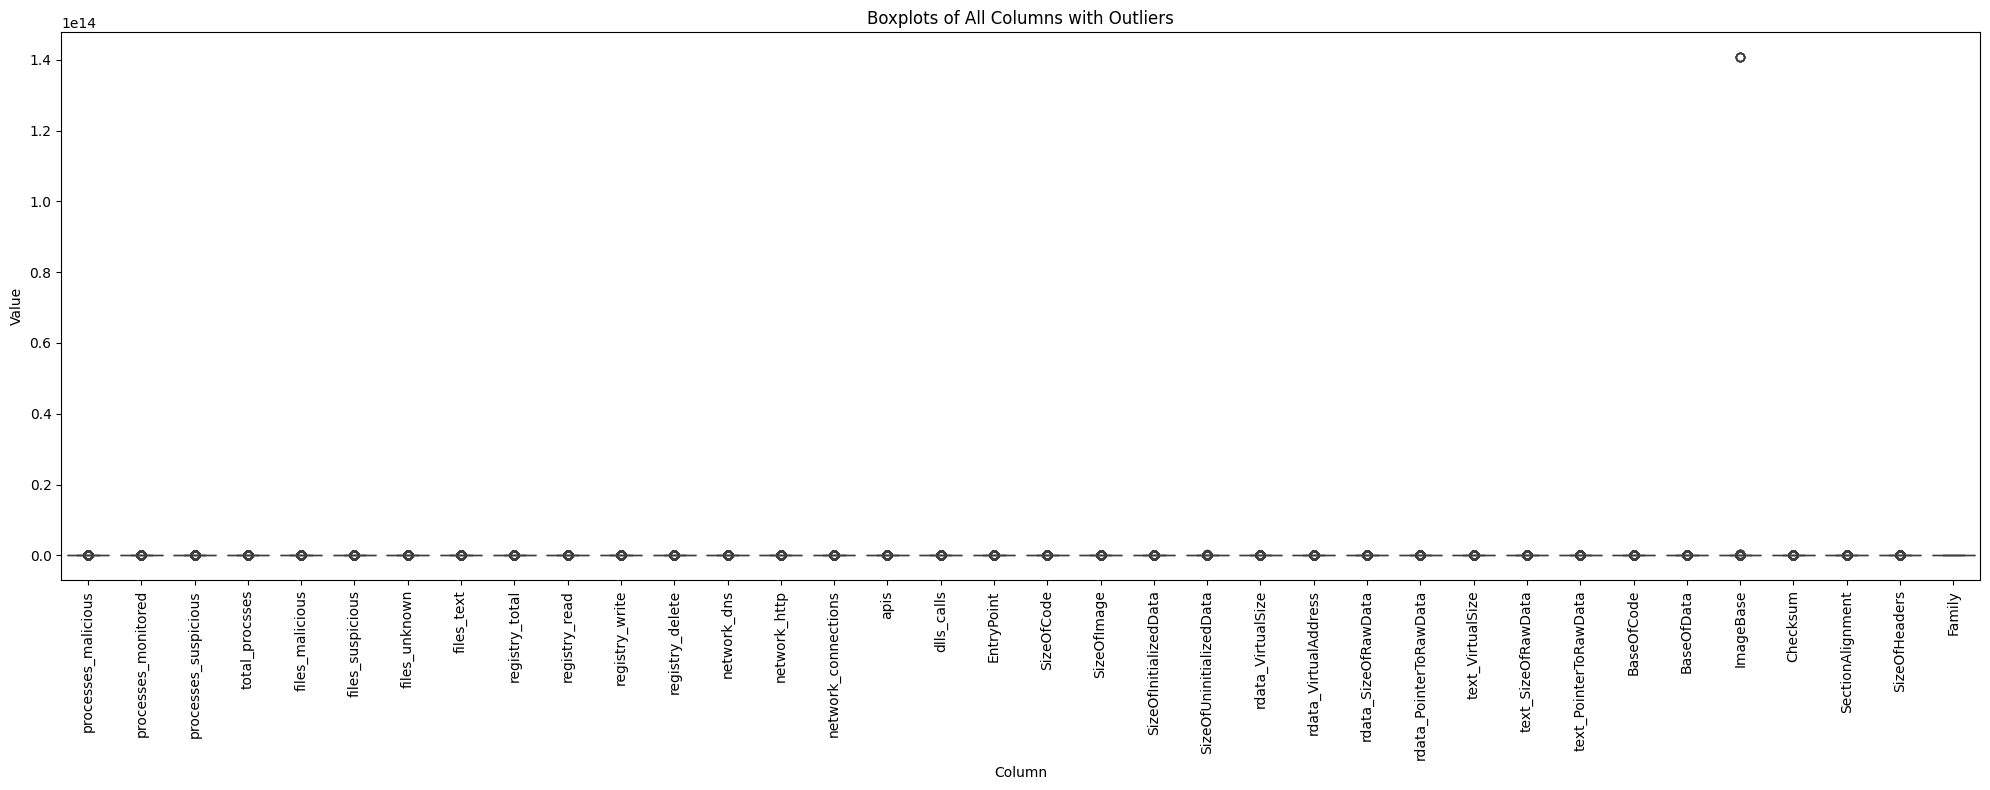

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert wide df (55 columns) into long format
df_melted = df.melt(var_name="Column", value_name="Value")

plt.figure(figsize=(20, 8))  # wider figure to fit all columns on x-axis
sns.boxplot(x="Column", y="Value", data=df_melted)

plt.xticks(rotation=90)  # rotate labels for readability
plt.title("Boxplots of All Columns with Outliers")
plt.tight_layout()
plt.show()


In [12]:
outliers_per_column = {}
for col in df.select_dtypes(include=np.number).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outliers_per_column[col] = len(outliers)

In [13]:
outliers_per_column

{'processes_malicious': 1307,
 'processes_monitored': 2860,
 'processes_suspicious': 3061,
 'total_procsses': 3914,
 'files_malicious': 3633,
 'files_suspicious': 4614,
 'files_unknown': 4613,
 'files_text': 4157,
 'registry_total': 2935,
 'registry_read': 2919,
 'registry_write': 4460,
 'registry_delete': 2626,
 'network_dns': 3044,
 'network_http': 4231,
 'network_connections': 1537,
 'apis': 1587,
 'dlls_calls': 862,
 'EntryPoint': 2678,
 'SizeOfCode': 2503,
 'SizeOfImage': 3251,
 'SizeOfInitializedData': 3691,
 'SizeOfUninitializedData': 2114,
 'rdata_VirtualSize': 3650,
 'rdata_VirtualAddress': 3115,
 'rdata_SizeOfRawData': 3490,
 'rdata_PointerToRawData': 3039,
 'text_VirtualSize': 2467,
 'text_SizeOfRawData': 2701,
 'text_PointerToRawData': 10388,
 'BaseOfCode': 3034,
 'BaseOfData': 2757,
 'ImageBase': 4326,
 'Checksum': 3618,
 'SectionAlignment': 2084,
 'SizeOfHeaders': 8933,
 'Family': 0}

In [14]:
#Cap Outliers (Winsorize / Clipping Approach)
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower, lower,
                 np.where(df[column] > upper, upper, df[column]))
    return df

# Apply to columns with outliers
for col, count in outliers_per_column.items():
    if count > 0:
        df = cap_outliers_iqr(df, col)

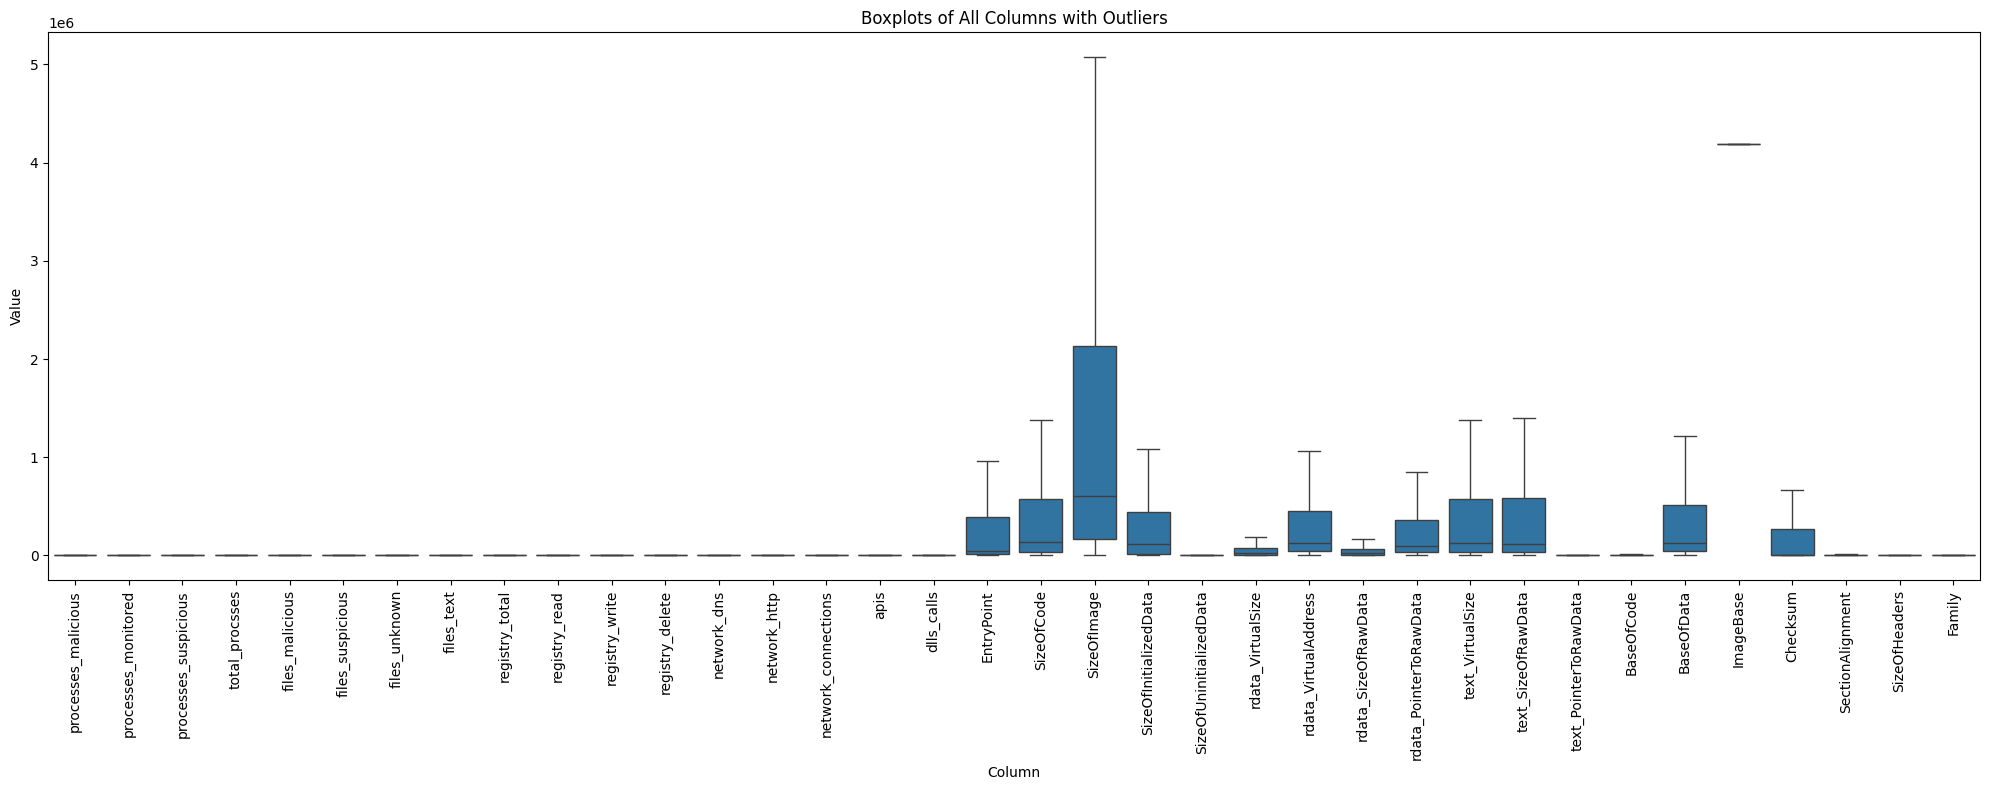

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert wide df (55 columns) into long format
df_melted = df.melt(var_name="Column", value_name="Value")

plt.figure(figsize=(20, 8))  # wider figure to fit all columns on x-axis
sns.boxplot(x="Column", y="Value", data=df_melted)

plt.xticks(rotation=90)  # rotate labels for readability
plt.title("Boxplots of All Columns with Outliers")
plt.tight_layout()
plt.show()


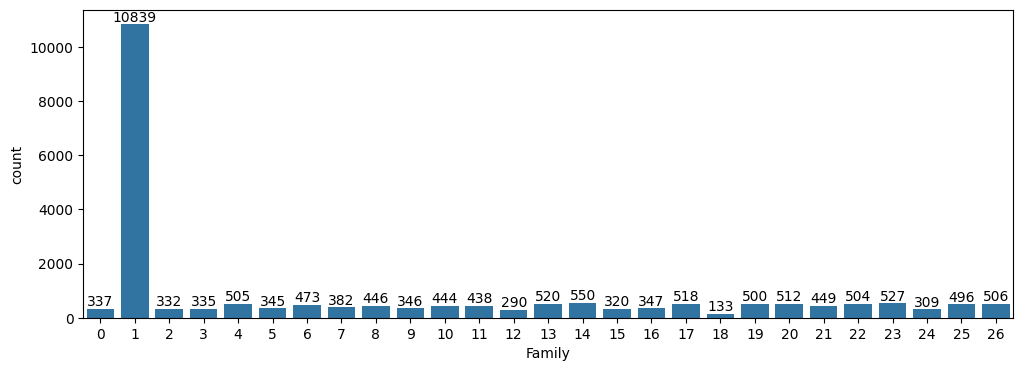

In [16]:
plt.figure(figsize=(12,4))
ax = sns.countplot(x='Family',data=df)
for i in ax.containers:
    ax.bar_label(i,)

In [17]:
import pandas as pd

# Separate benign (class 1) and malware (all others)
benign_df = df[df['Family'] == 1]
malware_df = df[df['Family'] != 1]

# Get the maximum malware count
max_count = malware_df['Family'].value_counts().max()

# Keep benign samples equal to max malware class
keep_count = max_count
benign_sampled = benign_df.sample(n=keep_count, random_state=42)

# Combine balanced dataset
balanced_df = pd.concat([benign_sampled, malware_df], axis=0).sample(frac=1, random_state=42)

print("Original counts:\n", df['Family'].value_counts())
print("\nBalanced counts:\n", balanced_df['Family'].value_counts())

Original counts:
 Family
1     10839
14      550
23      527
13      520
17      518
20      512
26      506
4       505
22      504
19      500
25      496
6       473
21      449
8       446
10      444
11      438
7       382
16      347
9       346
5       345
0       337
3       335
2       332
15      320
24      309
12      290
18      133
Name: count, dtype: int64

Balanced counts:
 Family
14    550
1     550
23    527
13    520
17    518
20    512
26    506
4     505
22    504
19    500
25    496
6     473
21    449
8     446
10    444
11    438
7     382
16    347
9     346
5     345
0     337
3     335
2     332
15    320
24    309
12    290
18    133
Name: count, dtype: int64


In [18]:
df.shape

(21703, 36)

In [19]:
balanced_df.shape

(11414, 36)

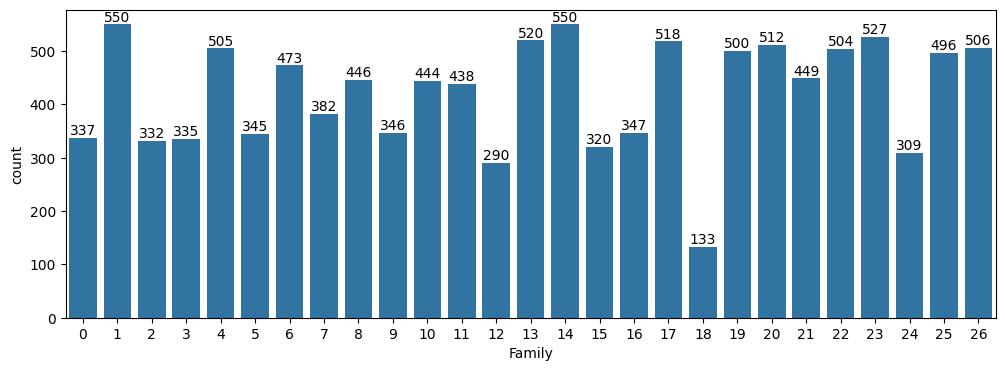

In [20]:
plt.figure(figsize=(12,4))
ax = sns.countplot(x='Family',data=balanced_df)
for i in ax.containers:
    ax.bar_label(i,)

<h3>Normalization</h3>

In [21]:
from sklearn.preprocessing import StandardScaler
# Create a Min-Max scaler instance
scaler = StandardScaler()
# Select the columns you want to scale (exclude the target variable if needed)
columns_to_scale = balanced_df.columns  # You can select specific columns here

# Fit the scaler on the selected columns and transform the data
balanced_df[columns_to_scale] = scaler.fit_transform(balanced_df[columns_to_scale])

<h3>Spliting for Training and Testing</h3>

In [22]:
# Separate features and labels
X = balanced_df.iloc[:, :-1].values  # Features
y = balanced_df.iloc[:, -1].values   # Class labels
X.shape

(11414, 35)

In [23]:
y.shape

(11414,)

<h3>ML Models Implementation</h3>


🔹 Training Logistic Regression...
Logistic Regression Performance:
  Accuracy:  0.8016
  Precision: 0.8027
  Recall:    0.8016
  F1-score:  0.8012

Classification Report:
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00        67
      Cerber       0.96      0.93      0.94       110
    DarkSide       0.76      0.83      0.80        66
      Dharma       0.90      0.91      0.90        67
    Gandcrab       0.85      0.78      0.81       101
     LockBit       0.71      0.80      0.75        69
        Maze       0.85      0.79      0.82        95
      Phobos       0.84      0.75      0.79        76
      Ragnar       0.73      0.76      0.75        89
       REvil       0.93      0.94      0.94        69
        Ryuk       0.83      0.80      0.81        89
       Shade       0.74      0.83      0.78        88
    WannaCry       0.86      0.93      0.89        58
       Gh0st       0.67      0.69      0.68       104
    Glupteba    

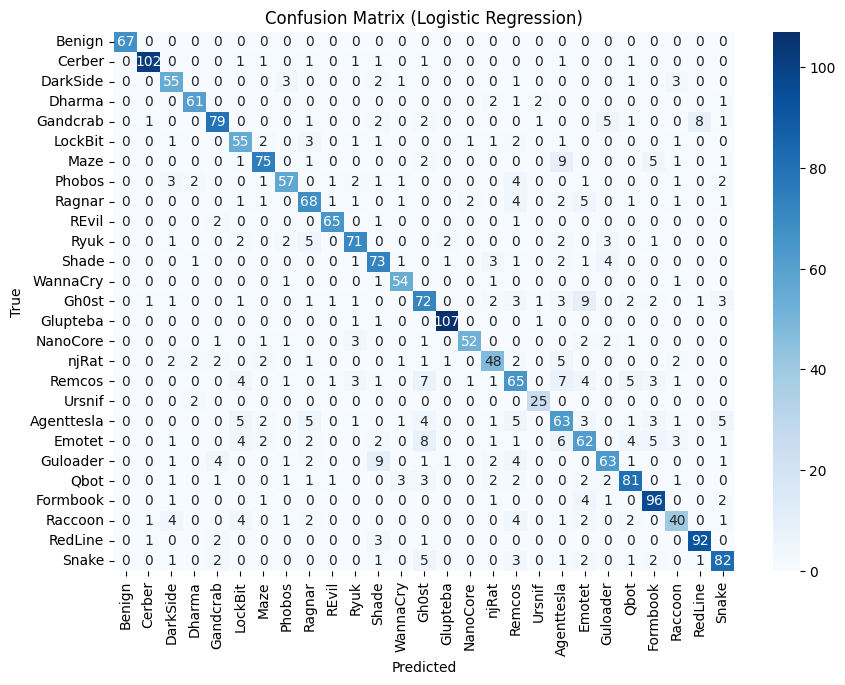


🔹 Training Random Forest...
Random Forest Performance:
  Accuracy:  0.9374
  Precision: 0.9384
  Recall:    0.9374
  F1-score:  0.9372

Classification Report:
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00        67
      Cerber       0.96      0.99      0.97       110
    DarkSide       0.96      0.97      0.96        66
      Dharma       0.97      1.00      0.99        67
    Gandcrab       0.99      0.96      0.97       101
     LockBit       0.96      0.96      0.96        69
        Maze       1.00      0.98      0.99        95
      Phobos       0.97      0.92      0.95        76
      Ragnar       0.96      0.81      0.88        89
       REvil       0.96      1.00      0.98        69
        Ryuk       0.93      0.96      0.94        89
       Shade       0.95      0.98      0.96        88
    WannaCry       0.95      1.00      0.97        58
       Gh0st       0.83      0.88      0.85       104
    Glupteba       0.97     

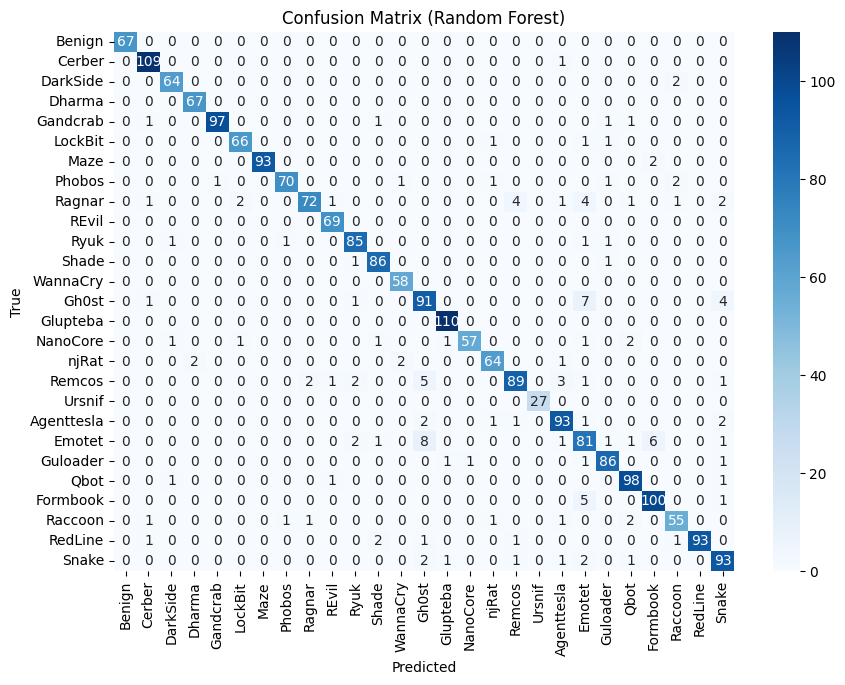


🔹 Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:54:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Performance:
  Accuracy:  0.9470
  Precision: 0.9474
  Recall:    0.9470
  F1-score:  0.9468

Classification Report:
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00        67
      Cerber       0.96      0.99      0.98       110
    DarkSide       0.94      0.97      0.96        66
      Dharma       0.99      1.00      0.99        67
    Gandcrab       1.00      0.96      0.98       101
     LockBit       0.92      0.99      0.95        69
        Maze       0.99      0.99      0.99        95
      Phobos       0.97      0.91      0.94        76
      Ragnar       0.94      0.85      0.89        89
       REvil       0.95      1.00      0.97        69
        Ryuk       0.97      0.98      0.97        89
       Shade       0.95      0.98      0.96        88
    WannaCry       0.94      1.00      0.97        58
       Gh0st       0.91      0.89      0.90       104
    Glupteba       0.99      0.99      0.99       110
    NanoC

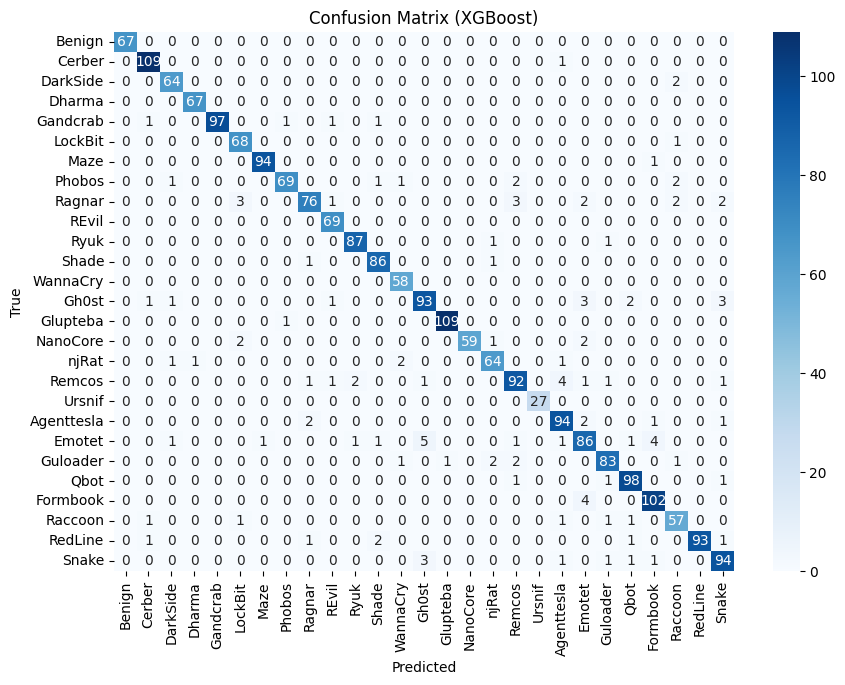


🔹 Training SVM...
SVM Performance:
  Accuracy:  0.8686
  Precision: 0.8708
  Recall:    0.8686
  F1-score:  0.8690

Classification Report:
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00        67
      Cerber       0.91      0.95      0.93       110
    DarkSide       0.87      0.89      0.88        66
      Dharma       0.87      0.93      0.90        67
    Gandcrab       0.88      0.91      0.89       101
     LockBit       0.85      0.90      0.87        69
        Maze       0.95      0.92      0.93        95
      Phobos       0.86      0.83      0.85        76
      Ragnar       0.75      0.80      0.77        89
       REvil       0.92      0.97      0.94        69
        Ryuk       0.91      0.84      0.88        89
       Shade       0.84      0.89      0.86        88
    WannaCry       0.90      0.93      0.92        58
       Gh0st       0.75      0.77      0.76       104
    Glupteba       0.98      0.96      0.97     

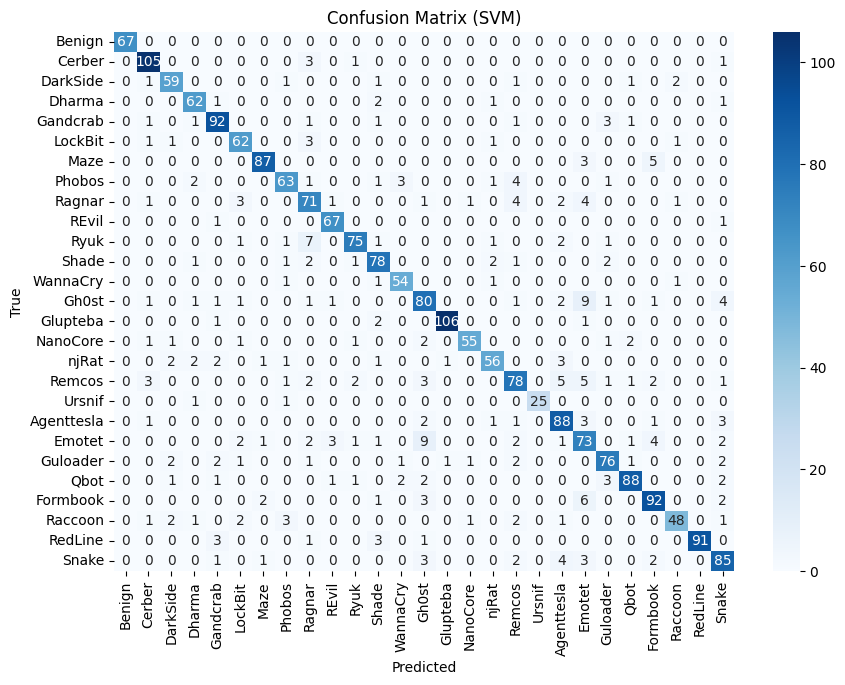


🔹 Training KNN...
KNN Performance:
  Accuracy:  0.8191
  Precision: 0.8196
  Recall:    0.8191
  F1-score:  0.8170

Classification Report:
               precision    recall  f1-score   support

      Benign       0.99      1.00      0.99        67
      Cerber       0.84      0.66      0.74       110
    DarkSide       0.89      0.88      0.89        66
      Dharma       0.77      0.90      0.83        67
    Gandcrab       0.83      0.89      0.86       101
     LockBit       0.72      0.83      0.77        69
        Maze       0.84      0.94      0.89        95
      Phobos       0.75      0.86      0.80        76
      Ragnar       0.79      0.74      0.76        89
       REvil       0.91      0.99      0.94        69
        Ryuk       0.83      0.89      0.86        89
       Shade       0.79      0.80      0.79        88
    WannaCry       0.87      0.90      0.88        58
       Gh0st       0.65      0.63      0.64       104
    Glupteba       0.91      0.97      0.94     

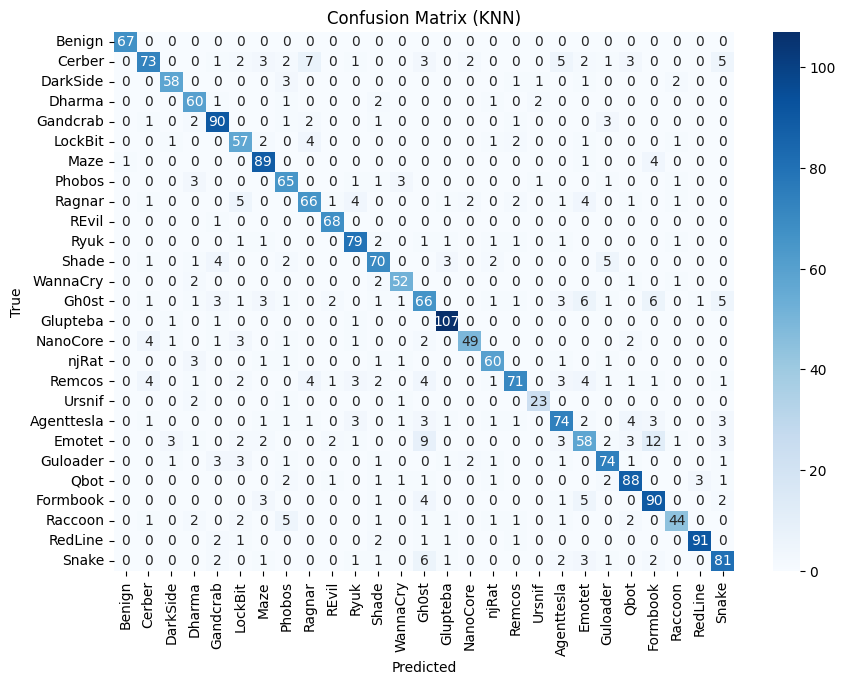


📊 Final Comparison:
                      Accuracy  Precision    Recall  F1-score
Logistic Regression  0.801577   0.802737  0.801577  0.801198
Random Forest        0.937363   0.938387  0.937363  0.937250
XGBoost              0.947000   0.947446  0.947000  0.946827
SVM                  0.868594   0.870833  0.868594  0.868971
KNN                  0.819098   0.819559  0.819098  0.816997


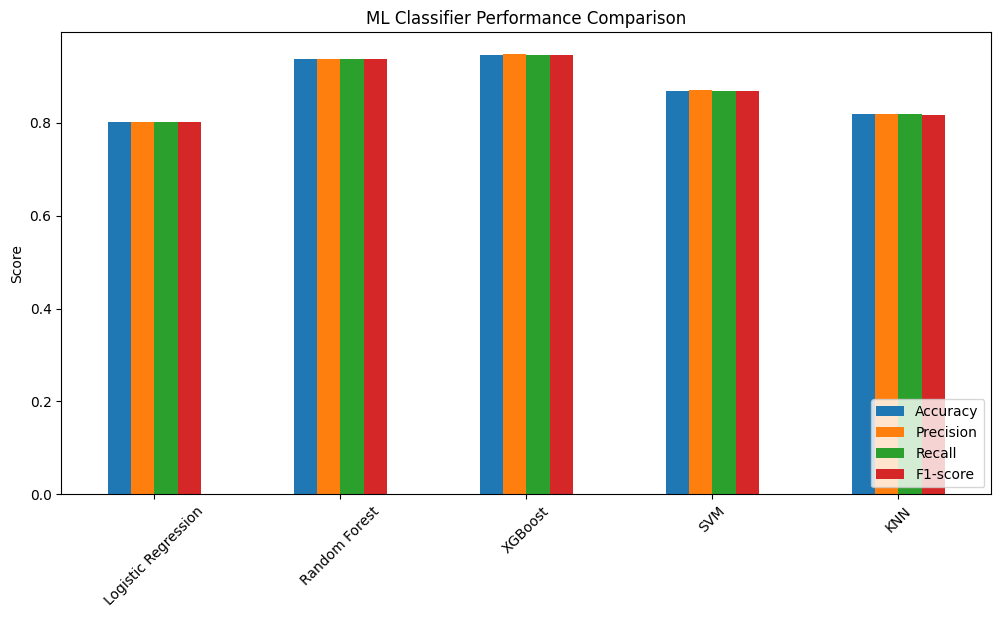

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# ML Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Feature scaling (important for SVM, KNN, LR)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# =====================================
# Define Models
# =====================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, use_label_encoder=False, eval_metric="mlogloss", random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7)
}

results = {}

# =====================================
# Train & Evaluate
# =====================================
for name, model in models.items():
    print(f"\n🔹 Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

    results[name] = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1-score": f1}

    print(f"{name} Performance:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-score:  {f1:.4f}")
    #print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=encoder.classes_.astype(str)))
    # Define your two class names
    class_names = ['Benign', 'Cerber', 'DarkSide', 'Dharma', 'Gandcrab', 'LockBit',
          'Maze', 'Phobos', 'Ragnar', 'REvil', 'Ryuk', 'Shade', 'WannaCry',
          'Gh0st', 'Glupteba', 'NanoCore', 'njRat', 'Remcos', 'Ursnif',
          'Agenttesla', 'Emotet', 'Guloader', 'Qbot', 'Formbook', 'Raccoon',
          'RedLine', 'Snake']

    print("\nClassification Report:\n", classification_report(
        y_test,
        y_pred,
        target_names=class_names
    ))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f"Confusion Matrix ({name})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(f"/content/drive/MyDrive/ML/Thesis/Dataset/Graphs/Models/family-ml-{name}.pdf")   # <-- save as PDF
    plt.show()

# =====================================
# Compare Results
# =====================================
results_df = pd.DataFrame(results).T
print("\n📊 Final Comparison:\n", results_df)

# Bar Plot Comparison
results_df.plot(kind="bar", figsize=(12,6))
plt.title("ML Classifier Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.savefig("/content/drive/MyDrive/ML/Thesis/Dataset/Graphs/Models/family-ml-compare.pdf")   # <-- save as PDF
plt.show()
